In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
import seaborn as sns
import sys
import torch

import warnings
#warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore')

In [2]:
from ZORO import benchmarkfunctions
from ZORO import optimizers

## Generate Data

In [3]:
# Dimensionality of data -- we tweak this to run our experiments
dim = 100             #10, 100, 1000, 10000
informative = 100     # 1,  10,  100,  1000

In [4]:
from sklearn.datasets import make_classification, make_blobs
# Cluster of points normally distributed (std=1) about vertices
# of an n_informative-dim hypercube with sides of length 2*class_sep

# Features are ordered: n_informative, n_redundant, n_repeated, 
# then random noise
def generate_samples(n_features, n_informative, n_samples=100):
    """
    return make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=2,
        random_state=42
        
    )
    """
    return make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_informative,
        n_redundant=0, 
        n_repeated=0, 
        n_classes=2, 
        n_clusters_per_class=1, 
        flip_y=0.01, 
        class_sep=2, 
        random_state=42,
        shuffle=False
    )

X, y = generate_samples(dim, informative)

### Plot of Projection onto 2 Dimensions

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

<AxesSubplot:>

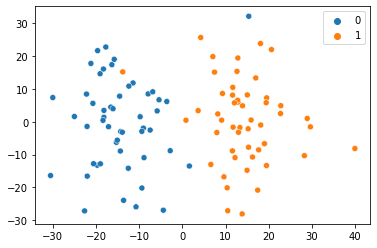

In [7]:
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=y)

## Linear Separator

In [8]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=42, max_iter=1000)
clf.fit(X, y)
print("Number of iterations", clf.n_iter_)
print("Accuracy:", clf.score(X, y))

Number of iterations 43
Accuracy: 1.0


In [9]:
clf.decision_function(X)

array([-0.99976088,  0.99920779, -1.55534527, -0.99998436, -2.41794348,
       -1.47220649, -2.01977723, -2.03966941, -1.85396544, -0.99995427,
       -1.54728386, -0.99972435, -1.58055126, -1.18490784, -0.99967094,
       -0.99975959, -0.99986584, -1.31001482, -0.99986491, -1.66870591,
       -0.99978134, -0.99995379, -0.99981438, -2.38032678, -2.52716479,
       -0.99993212, -0.99961138, -0.99972084, -1.74047396, -1.12811589,
       -1.68023677, -1.28672246, -2.00852424, -1.92673625, -1.30659427,
       -1.75715526, -2.12590067, -0.9999211 , -1.5177754 , -0.99972342,
       -0.99985145, -1.03745897, -1.13792929, -1.99260698, -1.44135978,
       -1.99669251, -0.99980017, -1.5227866 , -1.63514094, -1.27719268,
        0.99958419,  3.25206257,  1.2707888 ,  0.99972006,  2.83797669,
        1.9992384 ,  1.60147556,  0.99988933,  0.99995017,  1.45413373,
        0.99998746,  0.9998881 ,  1.73402975,  2.10996796,  0.99996068,
        1.69697992,  0.99969505,  1.82164648,  0.99991642,  2.77

In [10]:
y[y == 0] = -1
y

array([-1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [11]:
w_norm = np.linalg.norm(clf.coef_)

## ZORO Attack

In [12]:
# Adversarial Attack Loss
class AttackLoss(object):
    '''An implementation of the sparse quadric function.'''
    def __init__(self, predictor, lamb, norm, x_original, y_true, y_attack):
        self.predictor = predictor
        self.lamb = lamb
        self.norm = norm
        
        self.x_original = x_original
        self.y_true = y_true
        self.y_attack = y_attack
        
    def __call__(self, x_attack):
        ## (f(x + delta) - y_attack + y_true)^2 + lambda ||delta||_0
        prediction = self.predictor.decision_function(x_attack)
                
        return (prediction - self.y_attack)**2 \
              + self.lamb * np.linalg.norm((x_attack - self.x_original), self.norm, axis=1)

In [13]:
class ZOROExperiment:       
    
    def __init__(self, step_size=None, delta=None, max_cosamp_iter=None, 
                 cosamp_tol=None, prop_sparsity=None, lamb=None, norm=None,
                 function_budget=None):
        self.step_size = step_size
        self.delta = delta
        self.max_cosamp_iter = max_cosamp_iter
        self.cosamp_tol = cosamp_tol
        self.prop_sparsity = prop_sparsity
        self.lamb = lamb
        self.norm = norm
        self.function_budget = function_budget
        
    def score(self, X, y):
        return self.loss
    
    def get_params(self, deep=True):
        return {
            # Parameters for ZORO. 
            "step_size": self.step_size,
            "delta": self.delta,
            "max_cosamp_iter": self.max_cosamp_iter,
            "cosamp_tol": self.cosamp_tol,
            "prop_sparsity": self.prop_sparsity,
            "lamb" : self.lamb,
            "norm" : self.norm,
            "function_budget" : self.function_budget
        }
    
    def set_params(self, **kwargs):
        for parameter, value in kwargs.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, X, y):
        self.report = []
        
        params = {
            "step_size": self.step_size,
            "delta": self.delta,
            "max_cosamp_iter": self.max_cosamp_iter,
            "cosamp_tol": self.cosamp_tol,
            "prop_sparsity": self.prop_sparsity,
            "lamb" : self.lamb,
            "norm" : self.norm,
            "function_budget" : self.function_budget
        }
        
        params["sparsity"] = int(params["prop_sparsity"] * X.shape[1])
        params["num_samples"] = int(np.ceil(np.log(X.shape[1])*params["sparsity"]))

        # Compute attack loss for each data point individually
        for i in range(len(X)):
            x0           = X[i, :]
            xx0          = x0.copy()

            label        = y[i]
            label_attack = -y[i]

            obj_func = AttackLoss(
                predictor=clf, 
                lamb=self.lamb, 
                norm=self.norm, 
                x_original=xx0,
                y_true=label,
                y_attack=label_attack
            )

            # initialize optimizer object
            self.report.append([{"evals": 0, "x": x0, "y": label, "loss": obj_func(np.expand_dims(x0, 0))[0]}])
            opt = optimizers.ZORO(x0, obj_func, params, function_budget=self.function_budget, function_target=0.001)

            # the optimization routine
            termination = False
            while termination is False:
                # optimization step
                # solution_ZORO = False until a termination criterion is met, in which 
                # case solution_ZORO = the solution found.
                # termination = False until a termination criterion is met.
                # If ZORO terminates because function evaluation budget is met, 
                # termination = B
                # If ZORO terminated because the target accuracy is met,
                # termination= T.

                evals_ZORO, solution_ZORO, termination = opt.step()

                # save some useful values
                self.report[-1].append({"evals" : evals_ZORO, "x": solution_ZORO, "loss": np.mean(opt.fd)})
                # print some useful values
                #opt.report( f'Estimated f(x_{i}): %f  function evals: %d\n' %
                #    (np.mean(opt.fd), evals_ZORO) )
        self.loss = sum([self.report[i][-1]["loss"] for i in range(len(self.report))]) / len(self.report)

### Hyperparameter Search

In [14]:
# Parameters to search for ZORO attack
lamb = 0.1
params = {
    "step_size": [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    "delta": [1e-3, 1e-4, 1e-5], 
    "max_cosamp_iter": [5, 10, 15, 20, 25],
    "cosamp_tol": [0.5], 
    "prop_sparsity": [0.05, 0.10, 0.15, 0.20, 0.25], 
    "lamb" : [lamb], 
    "norm" : [2],
    "function_budget": [1e4] # for hyperparameter tuning, we give this as a budget
}

In [15]:
clf_search = sklearn.model_selection.RandomizedSearchCV(
    estimator = ZOROExperiment(),
    param_distributions = params,
    n_iter = 100, # Run 100 random trials
    n_jobs = 20, # Run 20 jobs at once
    refit = False,
    cv = ShuffleSplit(n_splits=1, train_size=16, random_state=42), # We attack the same 16 examples for every trial
    error_score=np.nan,
    random_state = 42
)

In [16]:
search_results = clf_search.fit(X, y)

/home/simonl2/.conda/envs/yeast-raytune2/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/simonl2/.conda/envs/yeast-raytune2/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/tmp/ipykernel_1705720/1368911766.py", line 86, in fit
  File "/home/simonl2/ndimensional/optml-project/ZORO/optimizers.py", line 89, in step
    grad_est, f_est = self.CosampGradEstimate()
  File "/home/simonl2/ndimensional/optml-project/ZORO/optimiz

In [17]:
import pandas as pd
# We see NaNs when numerical errors due to overflow occur (indicates a terrible hyperparam combination)
results_summary = pd.DataFrame(search_results.cv_results_).sort_values("mean_test_score")
results_summary.to_csv(f"gaussian_zoro_lambda{lamb}_d{dim}_20220616_report.tsv", sep="\t", index=False)

In [18]:
results_summary.sort_values("mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_step_size,param_prop_sparsity,param_norm,param_max_cosamp_iter,param_lamb,param_function_budget,param_delta,param_cosamp_tol,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
8,42.121542,0.0,0.000036,0.0,10.0,0.25,2,20,0.1,10000.0,0.0001,0.5,"{'step_size': 10.0, 'prop_sparsity': 0.25, 'no...",1.790341e+00,1.790341e+00,0.0,97
66,48.993463,0.0,0.000032,0.0,10.0,0.25,2,25,0.1,10000.0,0.00001,0.5,"{'step_size': 10.0, 'prop_sparsity': 0.25, 'no...",1.801663e+00,1.801663e+00,0.0,96
93,34.298540,0.0,0.000021,0.0,10.0,0.25,2,25,0.1,10000.0,0.001,0.5,"{'step_size': 10.0, 'prop_sparsity': 0.25, 'no...",1.809419e+00,1.809419e+00,0.0,95
53,47.501226,0.0,0.000032,0.0,10.0,0.2,2,15,0.1,10000.0,0.001,0.5,"{'step_size': 10.0, 'prop_sparsity': 0.2, 'nor...",1.978701e+00,1.978701e+00,0.0,94
82,42.632762,0.0,0.000023,0.0,10.0,0.2,2,5,0.1,10000.0,0.001,0.5,"{'step_size': 10.0, 'prop_sparsity': 0.2, 'nor...",2.004681e+00,2.004681e+00,0.0,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,37.762709,0.0,0.000025,0.0,100.0,0.05,2,20,0.1,10000.0,0.00001,0.5,"{'step_size': 100.0, 'prop_sparsity': 0.05, 'n...",1.025512e+01,1.025512e+01,0.0,2
99,9.419659,0.0,0.000019,0.0,100.0,0.25,2,15,0.1,10000.0,0.00001,0.5,"{'step_size': 100.0, 'prop_sparsity': 0.25, 'n...",9.126524e+12,9.126524e+12,0.0,1
47,6.520475,0.0,0.000000,0.0,100.0,0.05,2,10,0.1,10000.0,0.0001,0.5,"{'step_size': 100.0, 'prop_sparsity': 0.05, 'n...",NaN,NaN,NaN,100
55,25.968282,0.0,0.000000,0.0,100.0,0.1,2,5,0.1,10000.0,0.001,0.5,"{'step_size': 100.0, 'prop_sparsity': 0.1, 'no...",NaN,NaN,NaN,98


### Train Best Model With Higher Budget

In [ ]:
rs = ShuffleSplit(n_splits=1, train_size=16, random_state=42)
# Recover the exact indices used for training (kind of hacky)
for train_index, test_index in rs.split(X):
    X_sel, y_sel = X[train_index], y[train_index]

In [ ]:
best_params = search_results.cv_results_["params"][0]
best_params.update({"function_budget" : 1e4})
best_exp = ZOROExperiment(**best_params)
best_exp.fit(X_sel[:16,:], y_sel[:16])

#### Save Reports

In [ ]:
torch.save(best_exp.report, f"gaussian_zoro_lambda{lamb}_d{dim}_20220616_report.pt")

### Reload Best Attacker Data and Plot Graphs

In [ ]:
report = torch.load(f"gaussian_zoro_lambda{lamb}_d{dim}_20220616_report.pt")

In [ ]:
data_point = []

iteration = []
number_evals = []
perturbation_norms = []
predictions = []
labels = []

for i in range(len(report)):
    data_point.extend([i] * len(report[i]))
    original = report[i][0]["x"]
    labels.extend([report[i][0]["y"]] * len(report[i]))

    iteration.extend(range(len(report[i])))
    number_evals.extend(report[i][j]["evals"] for j in range(len(report[i])))
    perturbation_norms.extend([np.linalg.norm(original - report[i][j]["x"], 2) for j in range(len(report[i]))])
    predictions.extend(clf.decision_function(np.stack([report[i][j]["x"] for j in range(len(report[i]))])).tolist())
    
results_df = pd.DataFrame(
    {"data_point" : data_point,
     "iteration" : iteration,
      "number_evals": number_evals,
      "perturbation_norms": perturbation_norms,
      "predictions": predictions,
      "labels" : labels}
)

#### Fig 1

PCA of Data Points, Four Groupings:
1. Original Cluster 1
2. Original Cluster 2
3. Attack Points 1->2
4. Attack Points 2->1

In [ ]:
#selected = results_df[(results_df["data_point"] == j) & (results_df["iteration"] % 50 == 0)]
selected_X = np.stack([report[i][-1]["x"] for i in range(len(report))])

plt.figure(figsize=(5,5), dpi=200)
reduced_X = pca.transform(selected_X)
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], style=y)
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1], style=y_sel, hue=0, palette="magma")

#### Fig 2

PCA of Example Point:
1. Original Cluster 1
2. Original Cluster 2
3. Trace of Attack over Iterations

In [ ]:
j = 1
#selected = results_df[(results_df["data_point"] == j) & (results_df["iteration"] % 50 == 0)]
selected_X = np.stack([report[j][i]["x"] for i in range(len(report[j]))])[:30]
plt.figure(figsize=(5,5), dpi=200)
reduced_X = pca.transform(selected_X)
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], style=y)
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1], hue=range(len(reduced_X)), palette="flare")

#### Fig 3

Distance from Hyperplane (Vector Norm)

In [ ]:
plt.figure(figsize=(6, 4), dpi=300)
sns.lineplot(data=results_df, x="number_evals", y="predictions", hue="labels", style="data_point")
plt.ylabel("L2 Norm of Euclidean Distance")
plt.xlabel("Function Evaluations")
plt.title("Distance from Adversarial Example to Decision Boundary")

#### Fig 4

Distance from Input to Attack Vector (Vector Norm)

In [ ]:
plt.figure(figsize=(6, 4), dpi=300)
sns.lineplot(data=results_df, x="number_evals", y="perturbation_norms", hue="data_point")
plt.ylabel("L2 Norm of Euclidean Distance")
plt.xlabel("Function Evaluations")
plt.title("Distance from Adversarial Example to Original Example")